# 01 Intro to GLM
GLM and LM make *different assumptions about the response variable*
- While Linear models assume a *normally distributed* response variable, where the mean represents the center of the data, GLMs tend to constrain their response variable in some way.
    - In **Poisson** distributions, response varible is constrained to integers. Ex: Count data. 
       - Plotted, this distribution is normally right-skewed. Does not organise around a mean. 
- **Binomial** distributions constrains the response varible between 0 and 1- an all or nothing state. 

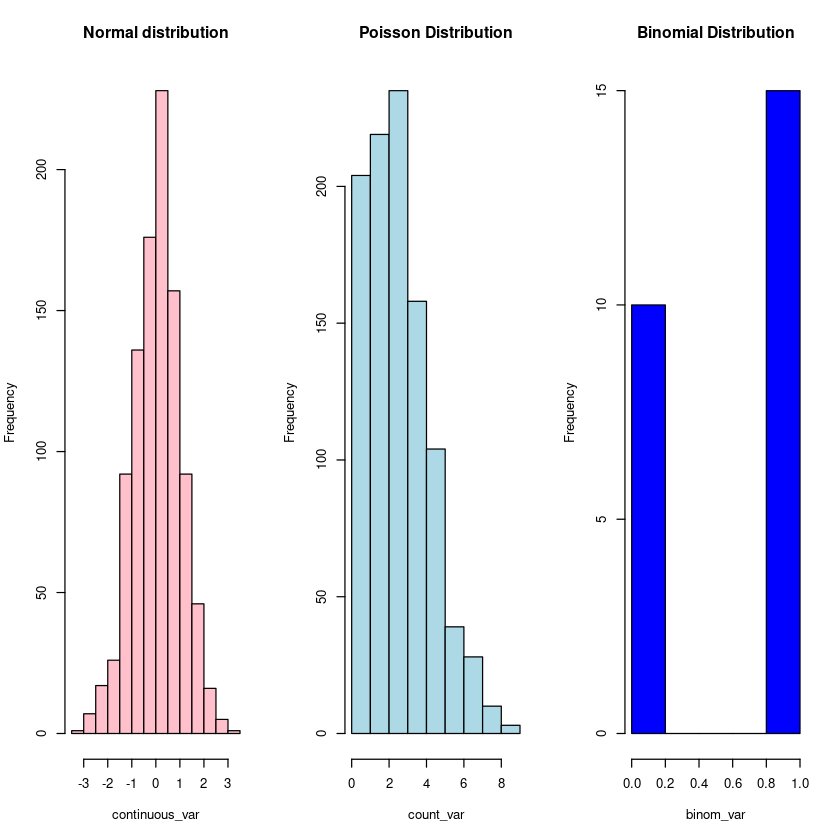

In [13]:
continuous_var <- rnorm(1000)
count_var <- rpois(1000, 3)
binom_var <- c(rep(1, 15), rep(0, 10))
par(mfrow=c(1,3))
hist(continuous_var, col="pink", main = "Normal distribution")
hist(count_var, col = "lightblue", main="Poisson Distribution")
hist(binom_var, col = "blue", main ="Binomial Distribution")

**Model fitting*
- Lm uses ordinary least squares method (OLS): fits a line that minimises sum of residual squared error
- GLM fits a line by minimising error via maximising its log-likelihood (probability of fit). 

Biggest difference is their assumptions around means and variance. OLS looks for a starry night of random, evenly distributed residuals (**Homoscedasticity**) around the mean. But sometimes we see **heteroscedasticity**- where a distribution of residuals change in an ordered way around the mean values. 

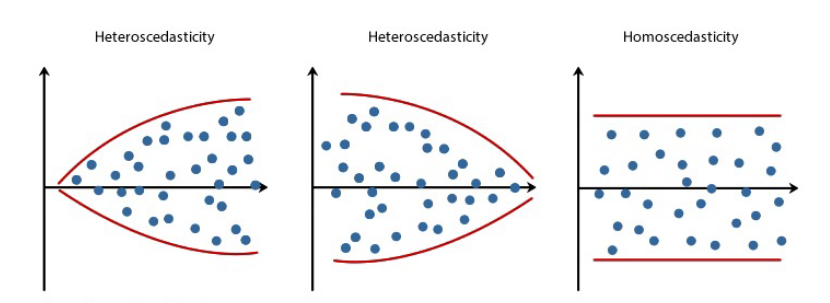

In these cases, it is sometimes possible to log transform the data (though would lose any zero data). OR, you can use a GLM, which does not assume normally distributed residuals!

## Using GLM
1. Identify the distribution of the response variable
2. Specify a linear function, or predictor function
$$
y_i = \beta_0 + \beta_1x_i+\epsilon_i
$$
3. Use a *link function* to link the predictor function and the mean of the distribution.
$$
h(y_i) = \beta_0 + \beta_1x_i+\epsilon_i
$$
- h() is our link function which we can choose based on the distribution of our response variable and linear predictor.

### Summary
- GLM are able to estimate linear estmates via MLE, and are able to handel constrained (non-continuous/normally distributed) data types
- The response variable is related to the linear predictor via a link function, which are specific to different distribution families

**LINK FUNCTIONS**:
- *Normal Distribution* uses the *Identity* Link- no change
- *Poisson Distribution* uses *log-linear* (natural) link
- *Binomial* uses *logit* link. 

# 02 Poisson Models
If your response data follows a poisson distribution (count data), can fit Poisson model by applying a **log-linear** transformation to your linear model (link function). 

*Example- Let's look to fish abundance at different depths

In [61]:
require(tidyverse)
require(MASS)
require(ggpubr)

fish <- read.csv("~/Downloads/fisheries.csv", stringsAsFactors= T)
head(fish)

,X,Site,TotAbund,Dens,MeanDepth,Year,Period,Xkm,Ykm,SweptArea
,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,1,76,0.002070281,0.804,1978,1,98.75575,-57.46692,36710.00
2,2,2,161,0.003519799,0.808,2001,2,76.80388,178.64798,45741.25
3,3,3,39,0.000980515,0.809,2001,2,103.79283,-50.05184,39775.00
4,4,4,410,0.008039216,0.848,1979,1,91.53227,146.44797,51000.00
5,5,5,177,0.005933375,0.853,2002,2,107.14419,-37.07544,29831.25
6,6,6,695,0.021800502,0.960,1980,1,86.56470,-48.19807,31880.00


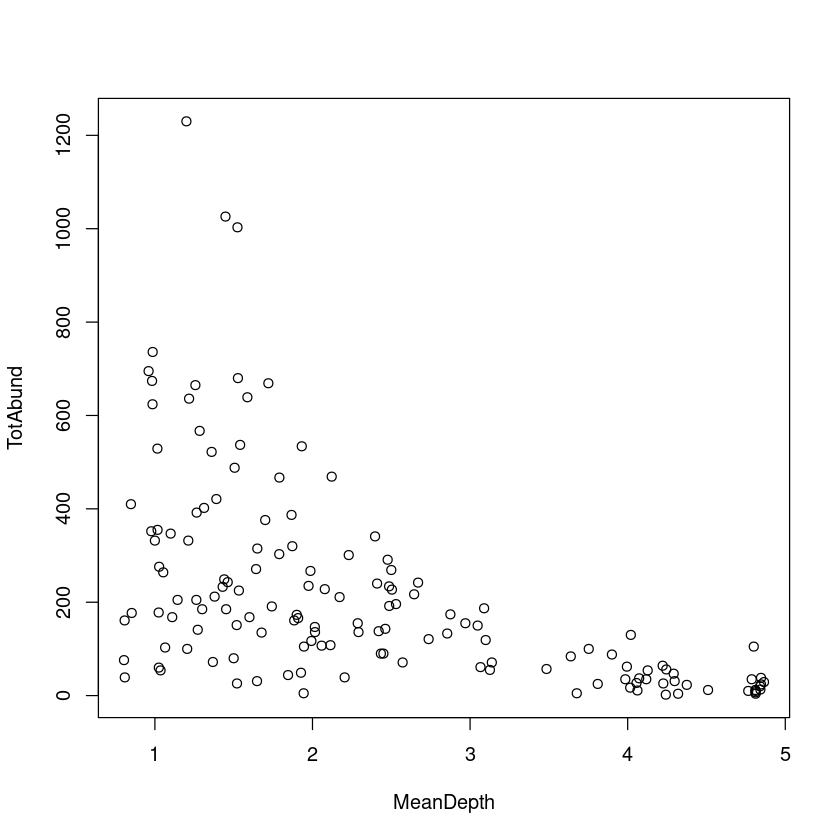

In [64]:
plot(TotAbund~MeanDepth, data=fish) # can see slightly right-skewed distribution

Basic linear model equation: 
$$
TotAbund =\beta_0+\beta_1*MeanDepth
$$
**Poisson link function:**
$$
in(TotAbund) =\beta_0+\beta_1*MeanDepth
$$

In [65]:
M1 <- glm(TotAbund~MeanDepth, data=fish, family="poisson")
summary(M1)


Call:
glm(formula = TotAbund ~ MeanDepth, family = "poisson", data = fish)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-25.544   -6.914   -3.046    3.901   35.744  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.64334    0.01273  521.70   <2e-16 ***
MeanDepth   -0.62870    0.00670  -93.84   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 27779  on 145  degrees of freedom
Residual deviance: 15770  on 144  degrees of freedom
AIC: 16741

Number of Fisher Scoring iterations: 5


## Interpreting coefficients
Similar results to lm. Here *z-value* is equivilent to a t-value in lm(). Both intercept and slope explain significant variation. 

THus, we can build our initial model, 
$$
log(TotAbund)=6.64+-0.62(MeanDepth)
$$
- For a km increase indepth, fish abundance decreases by a natural log of 0.62

Can back-transform these values to make function easier to interpret. Exponentiate. 
$$
y = e^{6.64+-0.62(MeanDepth)}
$$
- For a km increase in depth, fish abundance decreases by $e^-0.62$, or 0.53-fold

### Fold change
Since exponents not very informative, we want to report these exponential increases in terms of **Fold changes**
- Since we don't have a consistent slope, the increase rate depends on where we are in the function. Thus aggregate effect of body size is *multiplicative* rather than additive. 
    - As you add x, you multiply the response variable by a fold change. 
- The fold change is just the result of $e^{\beta_0+\beta_1x}$ where x=1

Means that for each increase in depth by 1km, we multiply the value of Abund at t-1 by the flold change: 
$$
1km: TotAbund= 1053.63*0.53 = 505.74
$$
$$
2km: TotAbund=505.74*0.53=242.76
$$
etc. etc.

### Null & Residual Deviance
glm() summary also returns values for null and residual deviance. 
- **Null deviance** summarises how well a null model predicts variance in y
- **Residual deviance** sumarises how well the model predicts variance in y

Using both, can calculate a *psuedo-Rsquared* value: 
$$
pseudoR^2 = 1-\frac{ResidDeviance}{NullDeviance}
$$
- How much variation the model explains. 

Pseudo$R^2$ for the above model equals: 1-(15770/2779)=0.43
- Depth accounts for 43% of variance in fish abundance. 

## Model Validation

### 1.  Model Diagnostics

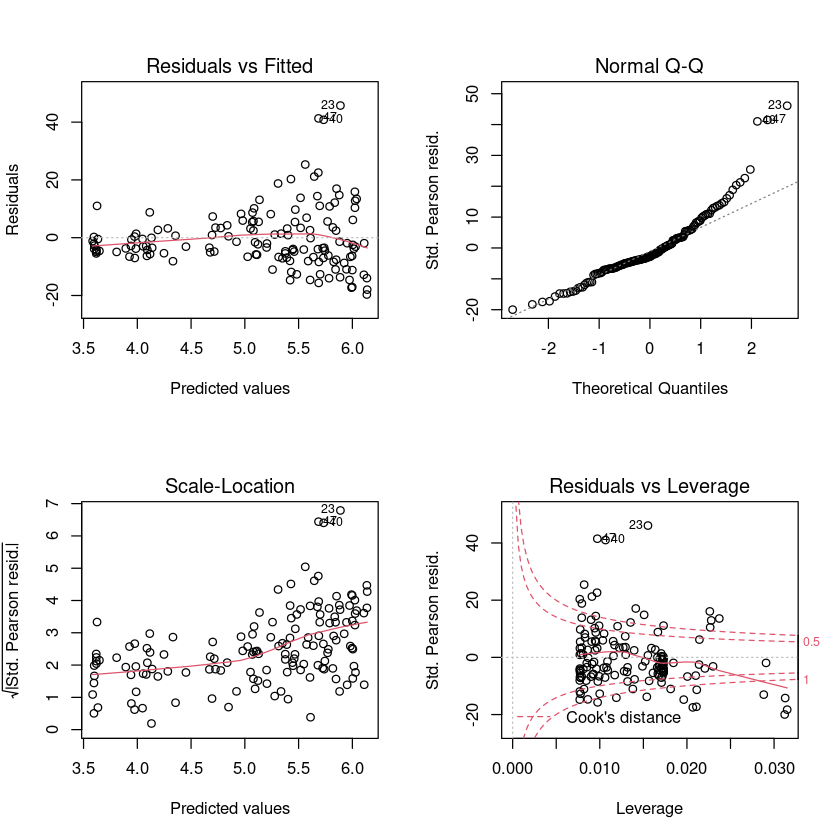

In [68]:
par(mfrow=c(2,2))
plot(M1)

- Residuals vs. leverage plot highlights a potentially large number of outliers. A cook's distance greater than 1 is considered an outliter. 

In [70]:
sum(cooks.distance(M1)>1) # a lot of outliers... suggests something missing in model

[1] 29

### 2. Dispersion
Secondly, need to calculate our *Dispersion* parameter- refers to the theoretical (expected) amount of variability based on the distribution you're using in your GLM. For the Poisson model, the dispersion parameter (expected variability) is 1. 
- ie. as the mean value increases, poisson assumes variance will increase too. 
- ie. residual deviance should be equal to number of points-paramters (df). Sum of square residuals should equal df, thus 1 unit of variation from mean. 

Calculated by dividing residual deviance by df (mean residual deviance)
$$
Dispersion = \frac{ResidDeviance}{df}
$$
- ie. Residual sum squares over degrees of freedom
- if dipsersion > 1, model is overdispered (variance much larger than mean)
    - The sum of squares is greater than the degrees of freedom- more than 1 each, or suff. number of residuals not explained by model.
- if dispersion <1, model is underdispersed

In [73]:
anova(M1)

,Df,Deviance,Resid. Df,Resid. Dev
,<int>,<dbl>,<int>,<dbl>
NULL,NA,NA,145,27778.67
MeanDepth,1,12008.9,144,15769.76


In our case, can calculate the dispersion parameter
$$
Dispersion = 15770/144 = 109.51
$$
- Our model is quite clearly overdispersed- variance being 109times higher than the conditional mean. 

##### Dealing with overdispersion
*Overdispersion* is common in poisson models, and could be the result of a large host of factors (from too simplistic a model to dependencies in the data etc.).

Other solutions include:
1. Can be accounted for by using **Quasi-likelihood** methods. exl quasi-poisson
    - Changes data from z-value to t-value and inflates the standard error to account for overdispersion

In [75]:
quasi_M <- glm(TotAbund~MeanDepth, family = "quasipoisson", data = fish)
anova(quasi_M) # no change in disspersion here

,Df,Deviance,Resid. Df,Resid. Dev
,<int>,<dbl>,<int>,<dbl>
NULL,NA,NA,145,27778.67
MeanDepth,1,12008.9,144,15769.76


2. **Negative binomial** approach: an overdispered poisson distribution converges with a negative binomial distribution, so can just use negative binomial model to find estimates and errors. 
- Poisson can be considered to be a special kind of negative binomial distribution

Best to try both and compare models for best fit. 

In [125]:
nb_M <- glm.nb(TotAbund~MeanDepth, data=fish)
anova(nb_M)
dispersion <- 158.74/144
cat("dispersion equals: ", dispersion) # much better

Warning message in anova.negbin(nb_M):
“tests made without re-estimating 'theta'”


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,145,316.5596,NA
MeanDepth,1,157.8122,144,158.7474,3.401628e-36


dispersion equals:  1.102361

[1] 41

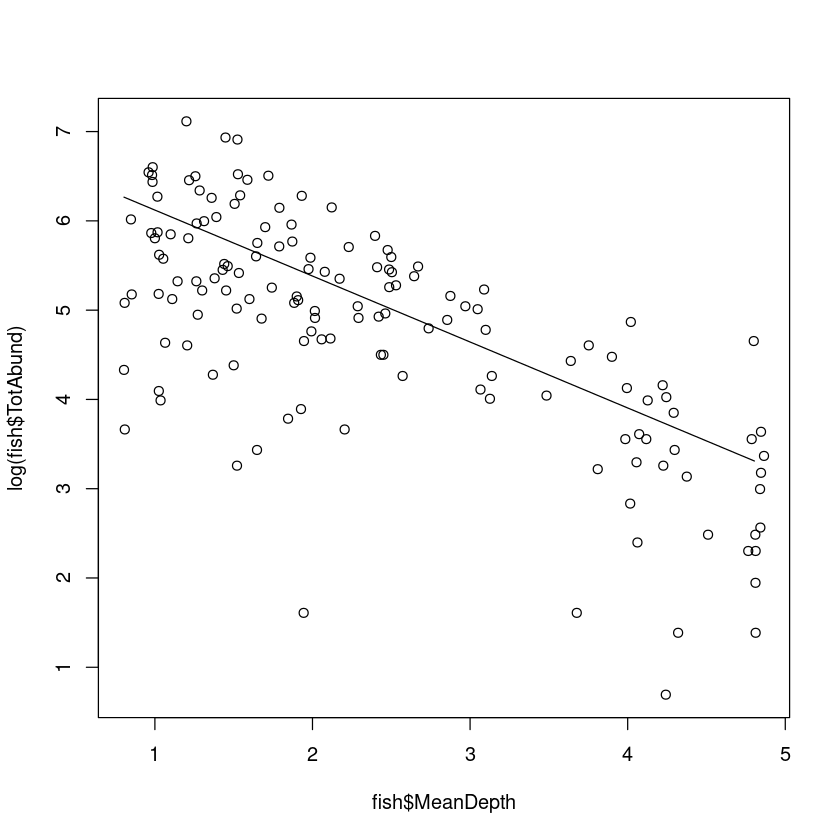

In [146]:
plot(log(fish$TotAbund)~fish$MeanDepth)
model_depth <- seq(min(fish$MeanDepth), max(fish$MeanDepth), 0.1)
depths <- as.data.frame(model_depth)
colnames(depths) <- "MeanDepth"
model_abund <- predict(nb_M, newdata=depths, se.fit=TRUE)
df <- data.frame(depths=model_depth, abundance = (model_abund$fit))
lines(df) # not bad

Additionally, our model could be missing an inherent dependency. Let's analyse effect of year. 

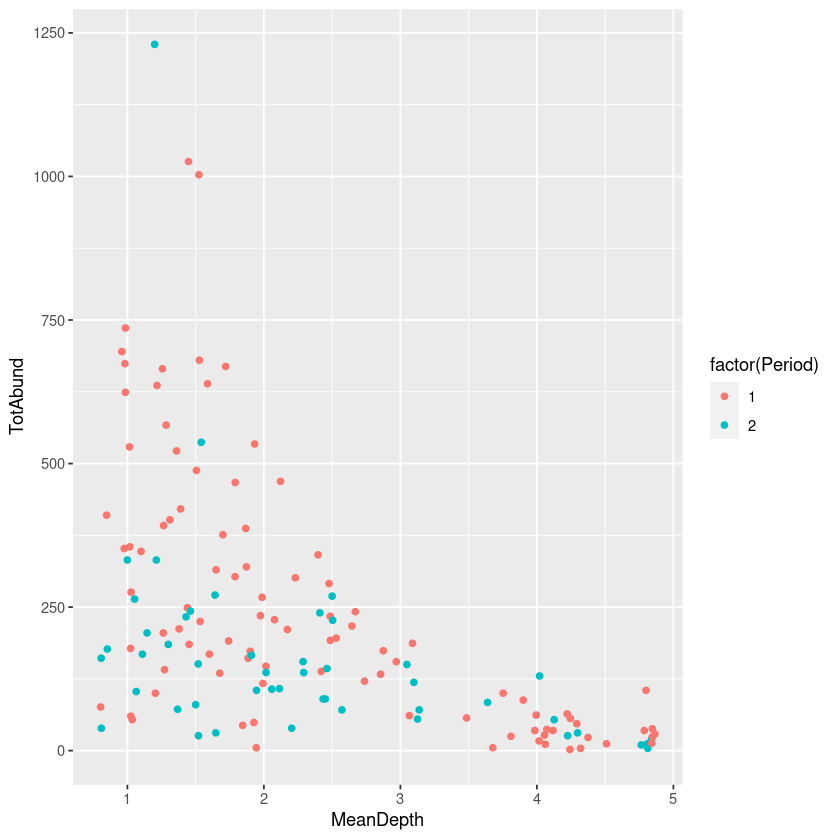

In [151]:
ggplot(fish, aes(x=MeanDepth, y=TotAbund, col=factor(Period))) + geom_point()
# does seem to be a trend- overall decrease in abundance over time
# Suggests periods might have two different slopes (interaction of period and depth)

In [153]:
# Add period as a fixed factor
M2 <- glm(TotAbund~MeanDepth*factor(Period), data=fish, family="poisson")
summary(M2)
psuedoR <- 1-(14293/27779)
cat("psuedo R squared is: ", psuedoR) #5% higher than previous model


Call:
glm(formula = TotAbund ~ MeanDepth * factor(Period), family = "poisson", 
    data = fish)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-25.298   -6.375   -1.721    3.323   44.621  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                6.832036   0.014837 460.473  < 2e-16 ***
MeanDepth                 -0.658858   0.007935 -83.031  < 2e-16 ***
factor(Period)2           -0.674857   0.029189 -23.120  < 2e-16 ***
MeanDepth:factor(Period)2  0.115712   0.014908   7.762 8.39e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 27779  on 145  degrees of freedom
Residual deviance: 14293  on 142  degrees of freedom
AIC: 15268

Number of Fisher Scoring iterations: 5


psuedo R squared is:  0.4854746

In [155]:
###### Check if influence is significant
anova(M2, test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,145,27778.67,NA
MeanDepth,1,12008.90303,144,15769.76,0.000000e+00
factor(Period),1,1417.93144,143,14351.83,2.666280e-310
MeanDepth:factor(Period),1,58.83745,142,14292.99,1.712502e-14


Period does have a significant influence. So our model is defined by two linear equations:

$$
Period1: in(TotAbund)= 6.83-0.66*MeanDepth
$$
$$
Period2: in(TotAbund)= 6.16-0.51*MeanDepth
$$
- Period two sees an overall drop in abundance, but now with a slight positive increase as MeanDepth increase. Meanwhile in period 1 totabund decreased with depth. 

$$
Dispersion = 14293/142 = 100.65
$$
- We've reduced disersion but still overdispered. 

In [158]:
# does this model explain significantly more variation? 
anova(M1,M2, test="Chisq") # difference is significant!

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,144,15769.76,NA,NA,NA
2,142,14292.99,2,1476.769,2.10966e-321


Lastly, let's try modelling this interaction with a negative binomial distribution

In [164]:
M3 <- glm.nb(TotAbund~MeanDepth*factor(Period), data=fish)
summary(M3)


Call:
glm.nb(formula = TotAbund ~ MeanDepth * factor(Period), data = fish, 
    init.theta = 1.982326313, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3257  -0.8038  -0.1655   0.4164   2.7953  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)                7.02270    0.15928  44.091   <2e-16 ***
MeanDepth                 -0.75841    0.05979 -12.686   <2e-16 ***
factor(Period)2           -0.60372    0.27167  -2.222   0.0263 *  
MeanDepth:factor(Period)2  0.08852    0.10120   0.875   0.3818    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.9823) family taken to be 1)

    Null deviance: 335.61  on 145  degrees of freedom
Residual deviance: 158.27  on 142  degrees of freedom
AIC: 1752.2

Number of Fisher Scoring iterations: 1


              Theta:  1.982 
          Std. Err.:  0.223 

 2 x log-likelihood:  -1742.201 

In [166]:
rsq <- 1-(158/335)
cat("Psuedo Rsquared: ", rsq)
dispersion <- 158.27/142
cat("\nDispersion: ", dispersion)

Psuedo Rsquared:  0.5283582
Dispersion:  1.114577

In [169]:
anova(M3, test="Chisq")

Warning message in anova.negbin(M3, test = "Chisq"):
“tests made without re-estimating 'theta'”


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,145,335.6081,NA
MeanDepth,1,167.3932033,144,168.2149,2.744998e-38
factor(Period),1,9.2916128,143,158.9233,2.302054e-03
MeanDepth:factor(Period),1,0.6528163,142,158.2705,4.191076e-01


Changing to this model has changed our model output significantly. This model suggests no significant difference between the slopes for each period, but there *is* a significant difference between the intercepts. 

So lastly, we can remove the model interaction, so period simply influences intercept. 

In [170]:
M4 <- glm.nb(TotAbund~MeanDepth+factor(Period), data=fish)
summary(M4)


Call:
glm.nb(formula = TotAbund ~ MeanDepth + factor(Period), data = fish, 
    init.theta = 1.97337518, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3119  -0.7930  -0.0909   0.4223   2.6109  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      6.95563    0.13596  51.159  < 2e-16 ***
MeanDepth       -0.72986    0.04836 -15.091  < 2e-16 ***
factor(Period)2 -0.39077    0.12553  -3.113  0.00185 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.9734) family taken to be 1)

    Null deviance: 334.13  on 145  degrees of freedom
Residual deviance: 158.23  on 143  degrees of freedom
AIC: 1750.9

Number of Fisher Scoring iterations: 1


              Theta:  1.973 
          Std. Err.:  0.222 

 2 x log-likelihood:  -1742.852 

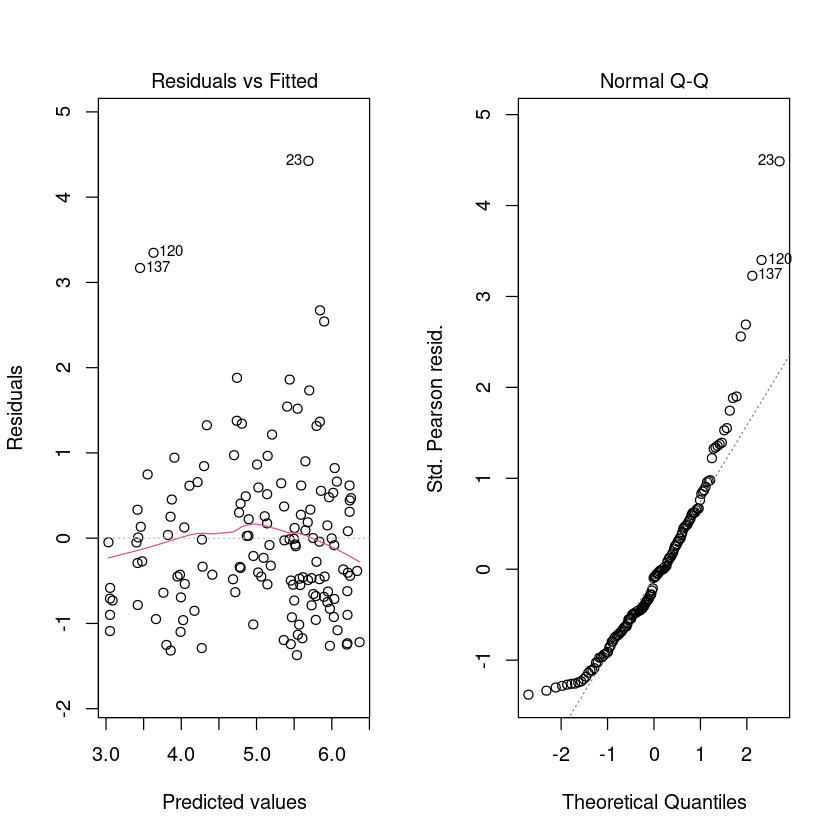

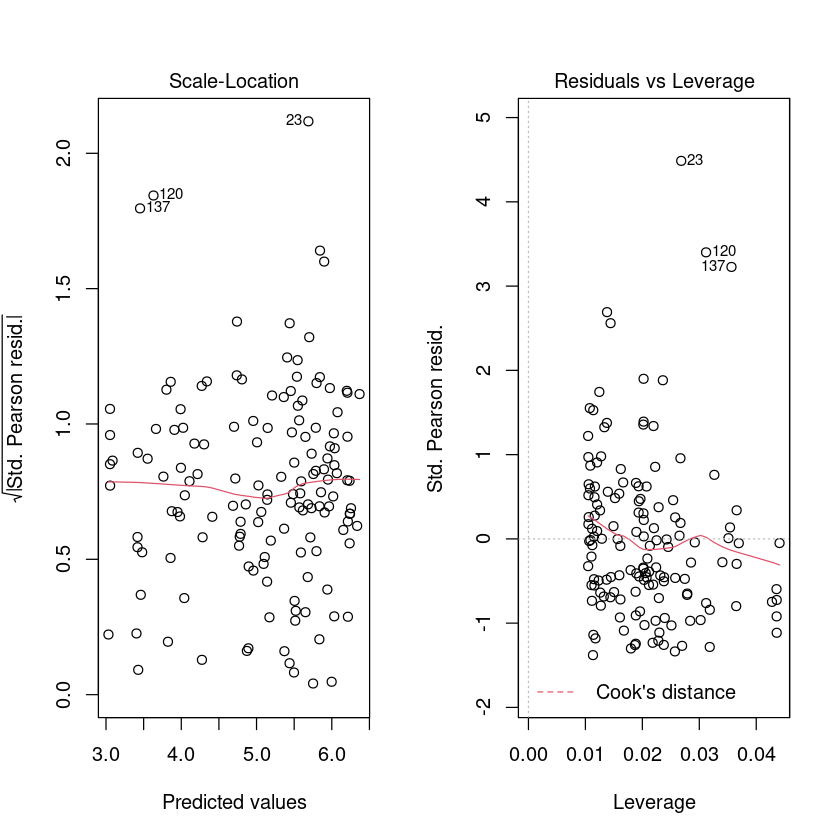

In [172]:
# Model Diagnostics
par(mfrow=c(1,2))
plot(M4)

Not near as many outliers in the final plot as with the Poisson distribution before. 

Our final Negative Binomial model is: 
$$
Period1: in(TotAbun) = 6.96 - 0.73*MeanDepth
$$
$$
Period2: in(TotAbun) = (6.96-0.39) - 0.73*MeanDepth
$$

- For every KM increase in depth, the abundance decreases by a factor of $e^-0.73$, or 0.48 fold. 

Laslty, let's plot the model

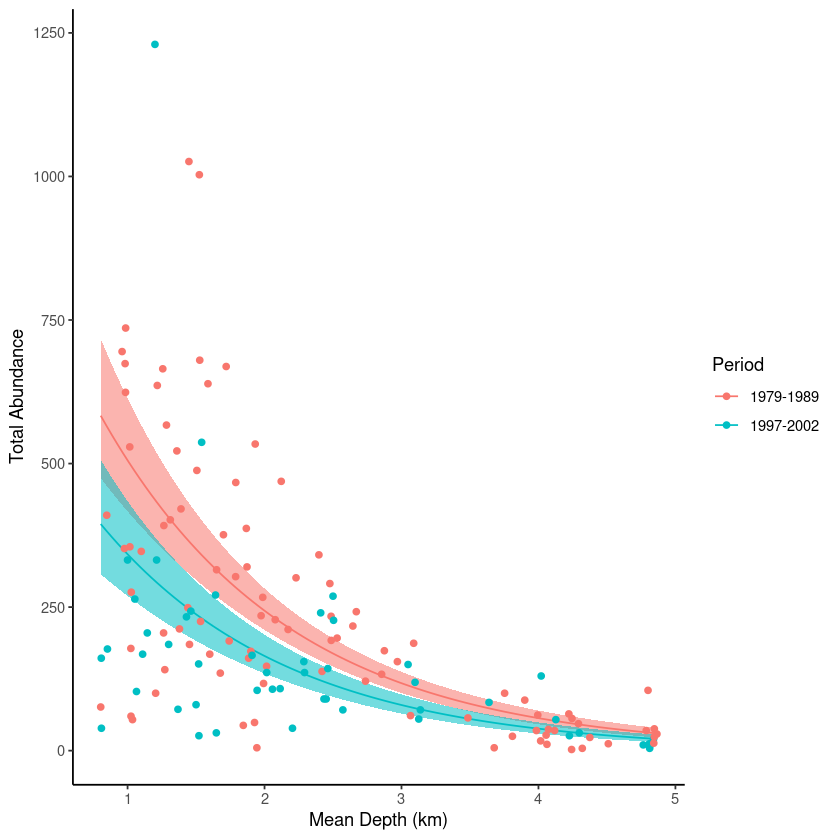

In [173]:
period1 <- data.frame(MeanDepth=seq(from=0.804, to=4.865, length=100), Period="1") 
period2 <- data.frame(MeanDepth=seq(from=0.804, to=4.865, length=100), Period="2") 
period1_predictions<- predict(M4, newdata = period1, type = "link", se.fit = TRUE) # the type="link" here predicted the fit and se on the log-linear scale.  
period2_predictions<- predict(M4, newdata = period2, type = "link", se.fit = TRUE) 
period1$pred<- period1_predictions$fit 
period1$se<- period1_predictions$se.fit 
period1$upperCI<- period1$pred+(period1$se*1.96) 
period1$lowerCI<- period1$pred-(period1$se*1.96) 
period2$pred<- period2_predictions$fit 
period2$se<- period2_predictions$se.fit 
period2$upperCI<- period2$pred+(period2$se*1.96) 
period2$lowerCI<- period2$pred-(period2$se*1.96) 
complete<- rbind(period1, period2) 

ggplot(complete, aes(x=MeanDepth, y=exp(pred)))+  
  geom_line(aes(color=factor(Period)))+ 
  geom_ribbon(aes(ymin=exp(lowerCI), ymax=exp(upperCI), fill=factor(Period), alpha=0.3), show.legend = FALSE)+  
  geom_point(fish, mapping = aes(x=MeanDepth, y=TotAbund, color=factor(Period)))+ 
  labs(y="Total Abundance", x="Mean Depth (km)")+ 
  theme_classic()+ 
  scale_color_discrete(name="Period", labels=c("1979-1989", "1997-2002")) 

## Example 2:  Mites
Mites were exposed to different concentrations of 4 commercially available pesticides (acaricides) and dead mites were counted over 24 hrs. How does increasing concentration impact the number of dead mites? 

,ID,Concentration,Acaricide,Dead_mites,Total,Proportion
,<int>,<dbl>,<int>,<int>,<int>,<dbl>
1,1,0.00,1,0,4,0.0
2,2,0.00,1,0,4,0.0
3,3,0.00,1,0,4,0.0
4,4,0.00,1,0,4,0.0
5,5,0.00,1,0,4,0.0
6,6,0.25,1,2,4,0.5


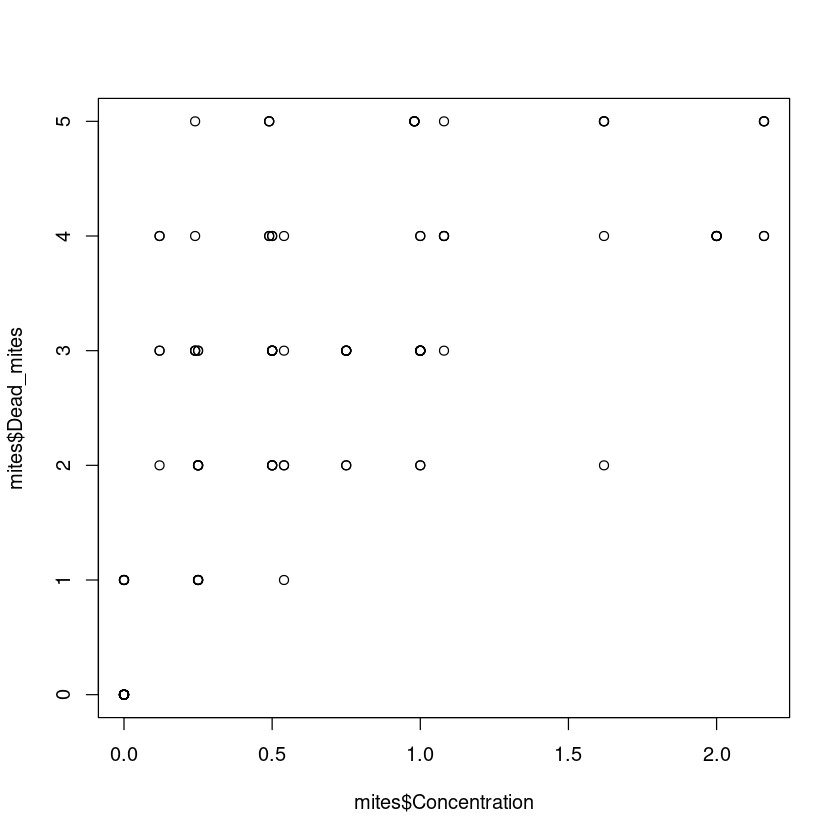

In [187]:
mites <- read.csv("~/Downloads/bee_mites.csv", stringsAsFactors=TRUE)
head(mites)
plot(mites$Dead_mites~mites$Concentration)

In [189]:
# fit poisson model
mites_m1 <- glm(Dead_mites~Concentration, data=mites, family="poisson")
summary(mites_m1)


Call:
glm(formula = Dead_mites ~ Concentration, family = "poisson", 
    data = mites)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.84167  -0.61720  -0.00242   0.47048   1.82502  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    0.52820    0.09316   5.670 1.43e-08 ***
Concentration  0.57181    0.08132   7.032 2.04e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 154.79  on 114  degrees of freedom
Residual deviance: 109.25  on 113  degrees of freedom
AIC: 398.71

Number of Fisher Scoring iterations: 5


In [190]:
# test if model is significant
anova(mites_m1, test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,114,154.7902,NA
Concentration,1,45.53526,113,109.2549,1.499153e-11


- Concentration seems to have significant impact on mite death. Increase in 1 unite of concentration means $e^{0.57}$ increase in dead mites, or a 1.7-fold increase in deadmites. 
- Psuedo-Rsquared= 1-109/154= 0.29. So although significant, concentration only accounts for 29% of variation in dead mites. 
- Dispersion= 109.25/113 = 0.97, so dispersion is very close to 1

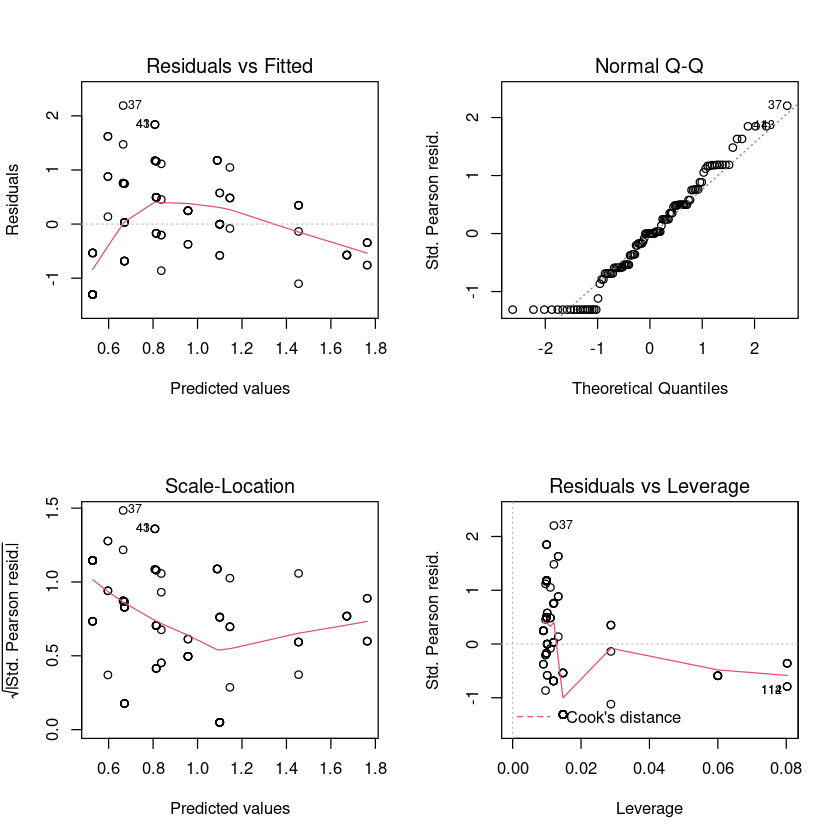

In [192]:
# model diagnostics
par(mfrow=c(2,2))
plot(mites_m1)

- Issue in the residuals vs. fitted plot: The line curves in a clear pattern. This means we have likely fitted an incorrect distribution. Although our data was count data, the total numer of mites varied across the trials. Thus we do not have strictly poisson data. 

Let's try fitting this data with a Binomial model

In [258]:
M5 <- glm(cbind(Dead_mites, Total-Dead_mites)~Concentration, data=mites, family="binomial")
summary(M5)


Call:
glm(formula = cbind(Dead_mites, Total - Dead_mites) ~ Concentration, 
    family = "binomial", data = mites)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.1331  -0.8957   0.2244   0.9934   2.7866  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -0.8728     0.1670  -5.227 1.73e-07 ***
Concentration   2.9687     0.3275   9.065  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 347.77  on 114  degrees of freedom
Residual deviance: 194.82  on 113  degrees of freedom
AIC: 294.85

Number of Fisher Scoring iterations: 5


In [259]:
anova(M5)

,Df,Deviance,Resid. Df,Resid. Dev
,<int>,<dbl>,<int>,<dbl>
NULL,NA,NA,114,347.7682
Concentration,1,152.9497,113,194.8186


- This model has a psuedo R squared of 0.439- concentration explains 44% of variance in dead mites (better than poisson model)
- Dispersion IS 1.72, so model is ever so slightly dispered. But not bad. 

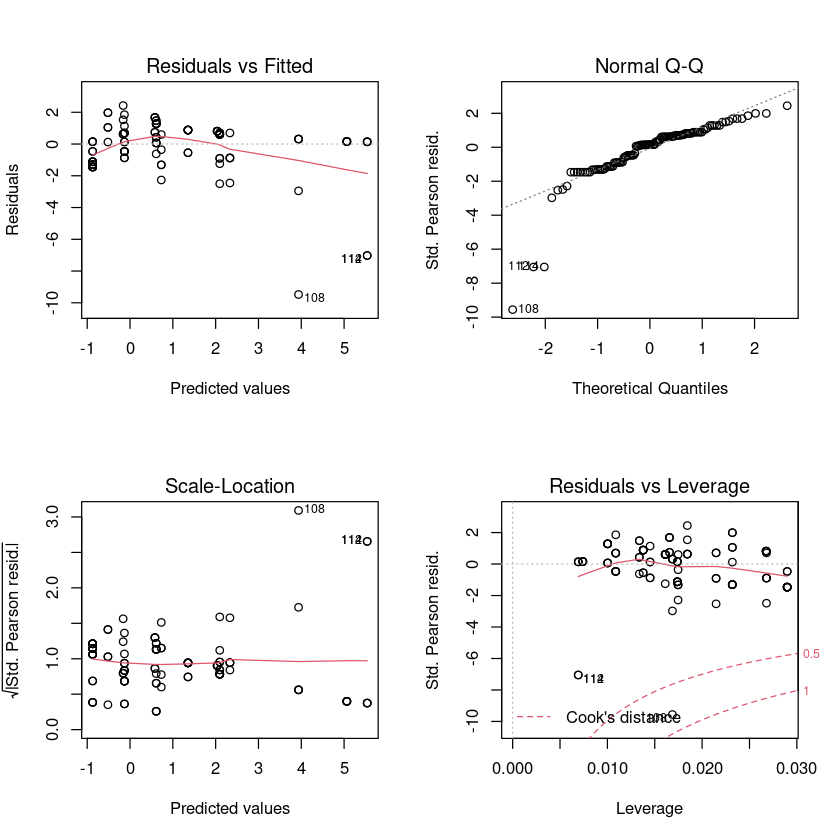

In [263]:
par(mfrow=c(2,2))
plot(M5)

- Plot still show a slight curve but generally using the binomial distribution has helped. Though there are still quite a few outliers in the last plot. 

Lastly, let's try using quasi-binomial model to help with this overdispersion. 

In [264]:
M6 <- glm(cbind(Dead_mites, Total-Dead_mites)~Concentration, data=mites, family="quasibinomial")

# 03 Binary and Binomial models
Response variable can be: 
- *binary* (encoded as 0,1; presence/absence)
- *binomial*: a probability value of a given outcome. (3/10 survived)
    $$
    p=\frac{k}{n}=\frac{NumberofSuccesses}{NumberofTrials}
    $$
    
Uses the ***logit* link function**: "The odds ratio"
$$
in(\frac{k}{n-k})
$$
- ie. number of successes/number of failures
$$
in(\frac{p}{1-p})
$$
- prob of success/prob of failure. 

In [194]:
worker <- read.csv("~/Downloads/workerbees.csv", stringsAsFactors=T)
head(worker) #presence or absence of parasite vs. cell size

,Parasites,CellSize
,<int>,<dbl>
1,0,0.424
2,0,0.454
3,0,0.457
4,0,0.468
5,0,0.493
6,0,0.558


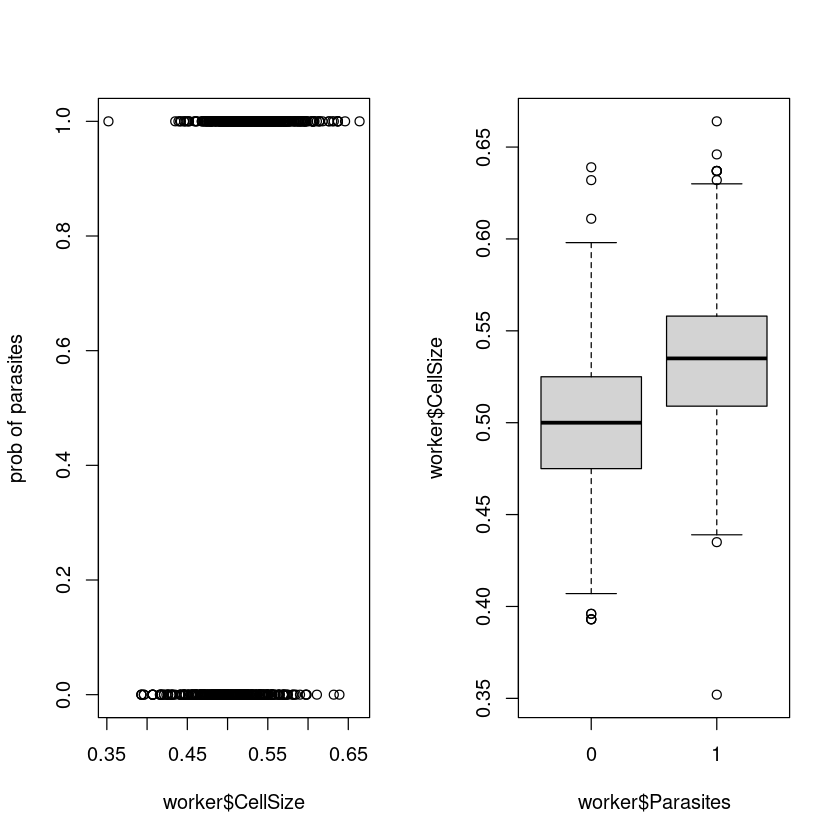

In [201]:
par(mfrow=c(1,2))
plot(worker$CellSize, worker$Parasites, ylab="prob of parasites")
# plot means of two groups
boxplot(worker$CellSize ~ worker$Parasites)

## Binary Model
**Does the probability of having a parasite increase with cell size?**
- Following function along binomial distribution: 

In [203]:
M1 <- glm(Parasites~CellSize, data=worker, family="binomial")
summary(M1)


Call:
glm(formula = Parasites ~ CellSize, family = "binomial", data = worker)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4403  -1.0570   0.5837   0.9878   2.6346  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -11.245      1.052  -10.69   <2e-16 ***
CellSize      22.175      2.034   10.90   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1259.6  on 916  degrees of freedom
Residual deviance: 1104.9  on 915  degrees of freedom
AIC: 1108.9

Number of Fisher Scoring iterations: 3


## Model Interpretation
Above we can appreciate similar output to lm (again z-value very simlar to t-value) etc. etc. Importantly, coefficients are still in **log odds ratios**:

$$
in\big(\frac{ProbParasite}{1-ProbParasite}\big)=\beta_0+\beta_1CellSize
$$

We can *back transform* them to get probability p:

$$
\frac{ProbParasite}{1-ProbParasite}=e^{\beta_0+\beta_1CellSize}
$$

$$
ProbParasite=\frac{e^(\beta_0+\beta_1CellSize)}{1 + e^{\beta_0+\beta_1CellSize}}
$$

In [244]:
# in R: use plogis
plogis(coef(M1))

(Intercept)     CellSize 
1.307548e-05 1.000000e+00

Thus, the model predicts probability is equal to: 
$$
p=\frac{e^{22.175}}{1+e^{22.175}} = 1
$$
- Intercept not biologically meaningful

For every unit increase in cell size, the probability of having a parasite increases by 100%. This makes sense when we look at the data! (A sudden jump from zero to one.)

### Finding the flip
When thinking about probabilities, most interested in the point where the probability flips, and you are suddenly *more* likely to do something. 
- This flip happens when the probability becomes greater than 0.5.

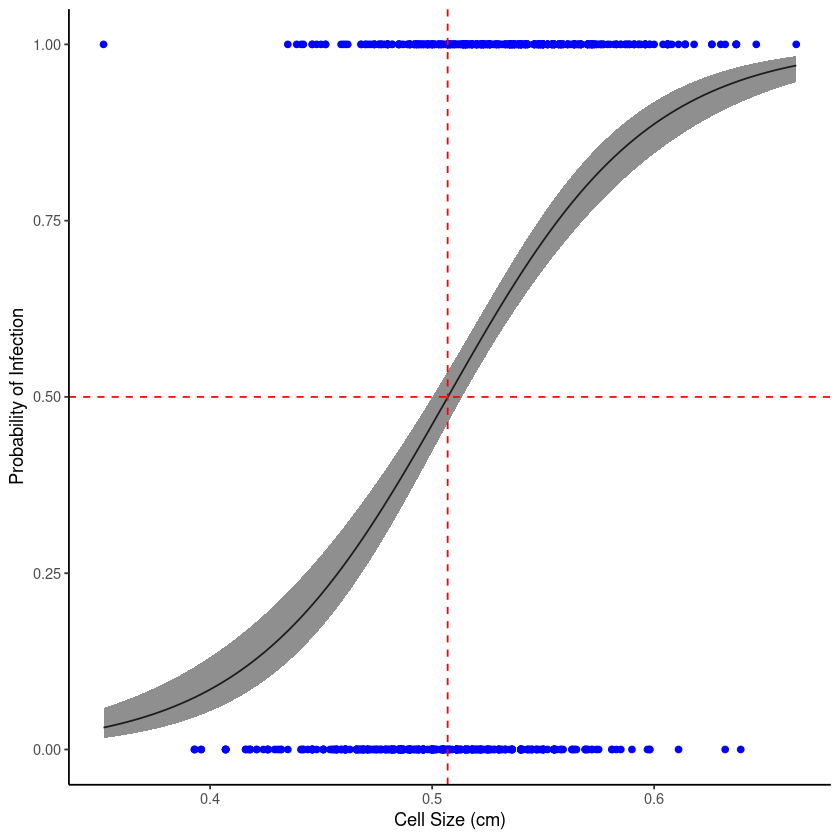

In [229]:
p + geom_hline(yintercept=0.5, col="red", linetype="dashed") + geom_vline(xintercept=0.507, col="red", linetype="dashed")

**Solutions**

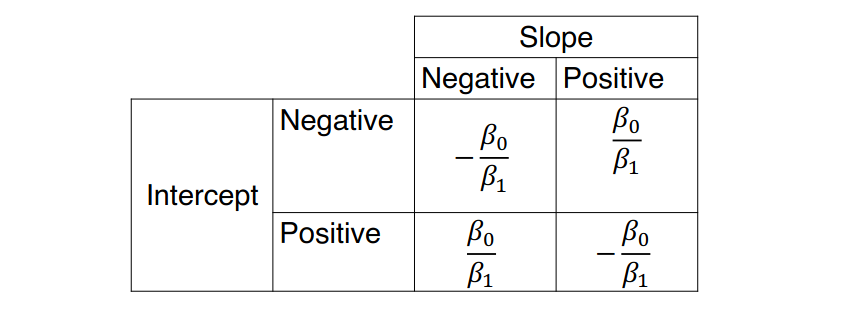

In our case, we have a negative intercept and positive slope:
$$
\frac{\beta_0}{\beta_1}=\frac{11.25}{22.175}=0.507
$$

Thus, cells greater than 0.507cm in size are more likely to have a parasite.

## Model validation
Lastly, our psuedo R-squared says the Cell size account for 12% of variation in prob of having a parasite. 
- Since data only consists of 0's and 1's, can't really use diagnstic plots. 

### Example: Infection in chytrids
Does spring time temperature affect the probability of infection in amphibians? 

In [240]:
chytrid <- read.csv("~/Downloads/chytrid.csv", stringsAsFactors=TRUE)
head(chytrid)

,Year,Site,Habitat,LarvalStage,InfectionStatus,AnnualaverageRf,AnnualaverageTmax,AnnualaverageTmin,AnnualaverageTavg,Springavgtemp
,<int>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2003,Ibon de Acherito,lake,Adult,1,2.731828,12.17415,2.348059,7.285958,11.538
2,2003,Ibon de Acherito,lake,Adult,1,2.731828,12.17415,2.348059,7.285958,11.538
3,2003,Ibon de Acherito,lake,Adult,1,2.731828,12.17415,2.348059,7.285958,11.538
4,2003,Ibon de Acherito,lake,Adult,0,2.731828,12.17415,2.348059,7.285958,11.538
5,2003,Ibon de Acherito,lake,Adult,1,2.731828,12.17415,2.348059,7.285958,11.538
6,2003,Ibon de Acherito,lake,Adult,1,2.731828,12.17415,2.348059,7.285958,11.538


In [241]:
M2 <- glm(InfectionStatus~Springavgtemp, data=chytrid, family="binomial")
summary(M2)


Call:
glm(formula = InfectionStatus ~ Springavgtemp, family = "binomial", 
    data = chytrid)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4683  -1.2470   0.9772   1.0860   1.1794  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.057236   0.055585  -1.030    0.303    
Springavgtemp  0.052629   0.008447   6.231 4.65e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 9310.0  on 6794  degrees of freedom
Residual deviance: 9270.7  on 6793  degrees of freedom
AIC: 9274.7

Number of Fisher Scoring iterations: 4


In [242]:
# get p
plogis(coef(M2))

(Intercept) Springavgtemp 
    0.4856950     0.5131542

- With every unit increase in average spring temperature, the probability of infection increases by 51%. 

**Flipping point**: negative intercept and positive slope
$$
\frac{\beta_0}{\beta_1}=-\frac{0.06}{0.05}=1.2C
$$
- Thus when temperature reaches 1.2 degrees celcius, frogs are more likely to have infection.

**Pseudo R-squared** says spring temperature accounts for 0.42% of variation in the presence/absence of infection (not very explanatory)

## Binomial Models
This time we are going to look to the probability of infection $in\big(\frac{k}{n-k}\big)$ as a function of spring time temperature (x):

$$ 
Binary: Infection\{0,1\}\sim Temperature
$$

$$
Binomial: ProbofInfection\sim Temperature
$$


In [247]:
chytrid_binomial<- read.csv("~/Downloads/chytrid_binomial.csv", stringsAsFactors = T)

Data looks at data not as a binary outcome (presence or absence of infection), but as binomial outcome: total positives/total negatives.
- Meanwhile, cbind gives of ratio of total presence to total absence or
$$
in\big(\frac{k}{n-k}\big)
$$

In [250]:
M3 <- glm(cbind(Positives, Total-Positives)~ AverageSpringTemp, family="binomial", data=chytrid_binomial)
summary(M3)


Call:
glm(formula = cbind(Positives, Total - Positives) ~ AverageSpringTemp, 
    family = "binomial", data = chytrid_binomial)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-9.9963  -4.6700  -0.0673   3.2884  11.6684  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -0.403670   0.037311  -10.82   <2e-16 ***
AverageSpringTemp  0.088839   0.005572   15.94   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5055.4  on 174  degrees of freedom
Residual deviance: 4795.7  on 173  degrees of freedom
AIC: 5410.5

Number of Fisher Scoring iterations: 4


In [251]:
anova(M3, test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,174,5055.383,NA
AverageSpringTemp,1,259.6426,173,4795.740,2.053166e-58


### Interpretation
- Average spring temperature does explain significant variance in probability of infection.
- Gives the following linear construct: 
$$
logit(probofinfection)=-0.4+0.09*AverageTemp
$$

Psuedo R-squared of 0.05- explains 5% of variance in probability of infection. 

### Model Validation
*Dispersion* = 4795.7/173 = 27.72
- Model is overdispersed, most likely because it's *too simplistic*: missing a number of variables that could introduct random effect (ex: year/location), fixed factors (lifestage, habitat). 
- Can see this overdisperal in below residuals vs. leverage plot: clearly lots of outliers.

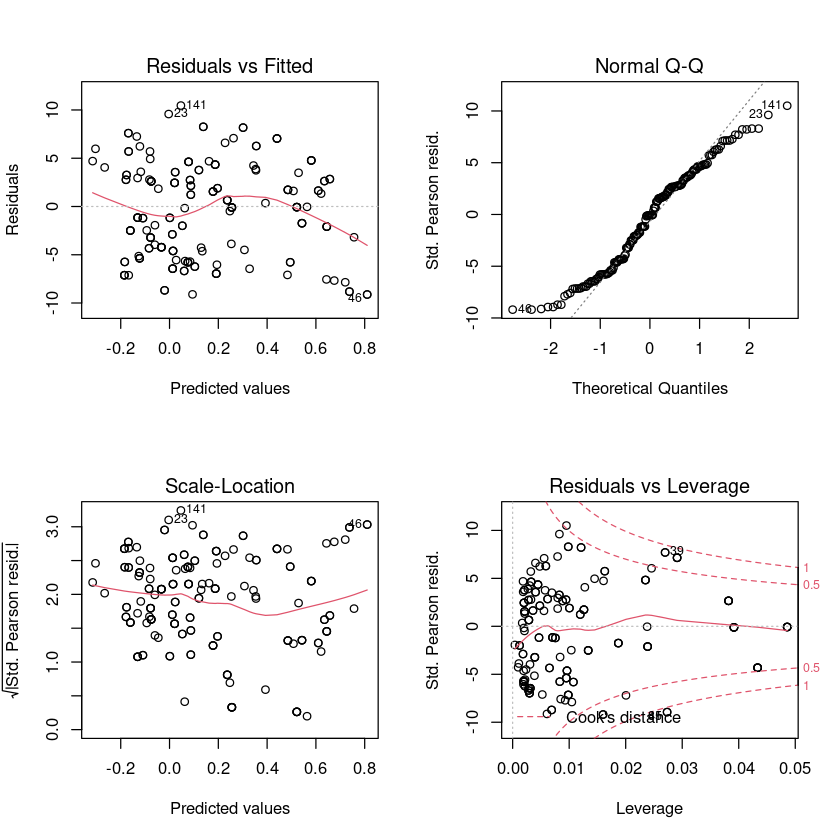

In [253]:
par(mfrow=c(2,2))
plot(M3)

### Quasi-Binomial model

In [254]:
# Try fitting a quasi-Binomial model
M4<- glm(cbind(Positives, Total-Positives)~AverageSpringTemp, data = chytrid_binomial, family = "quasibinomial") 
summary(M4) 


Call:
glm(formula = cbind(Positives, Total - Positives) ~ AverageSpringTemp, 
    family = "quasibinomial", data = chytrid_binomial)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-9.9963  -4.6700  -0.0673   3.2884  11.6684  

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)   
(Intercept)       -0.40367    0.18066  -2.234   0.0267 * 
AverageSpringTemp  0.08884    0.02698   3.293   0.0012 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasibinomial family taken to be 23.44436)

    Null deviance: 5055.4  on 174  degrees of freedom
Residual deviance: 4795.7  on 173  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 4


In [255]:
anova(M4, test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,174,5055.383,NA
AverageSpringTemp,1,259.6426,173,4795.740,0.0008750681


See above the estimated values do not change, but standard errors are inflated to account for overdispersion. This is model to plot.

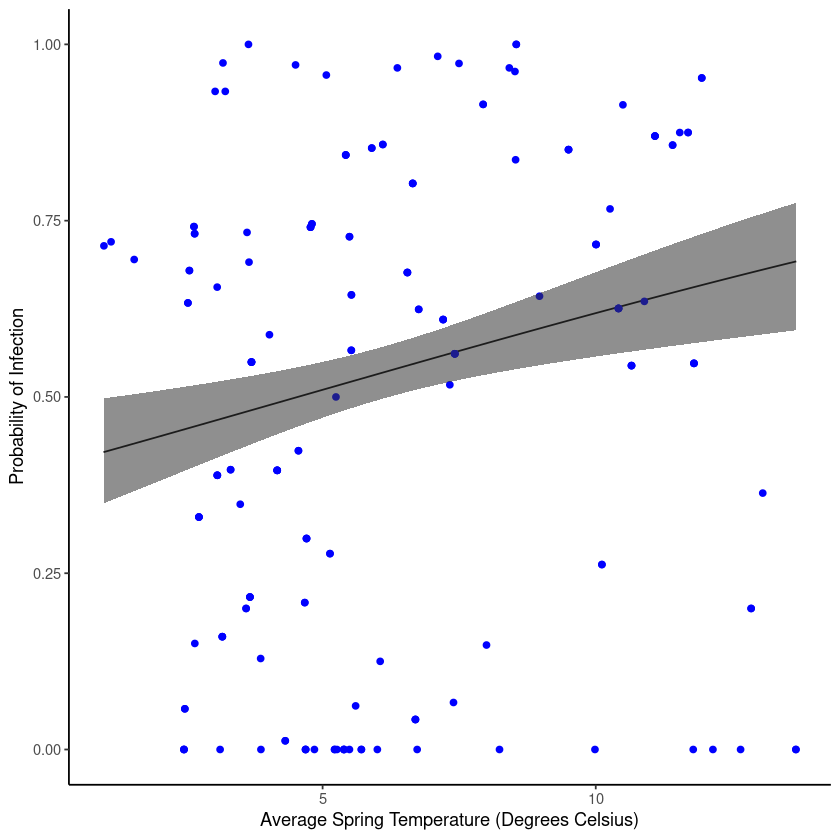

In [257]:
new_data <- data.frame(AverageSpringTemp=seq(from=0.99, to=13.67, length=100)) 
predictions<- predict(M4, newdata = new_data, type = "link", se.fit = TRUE) # the type="link" here predicted the fit and se on the log-linear scale.  
new_data$pred<- predictions$fit 
new_data$se<- predictions$se.fit 
new_data$upperCI<- new_data$pred+(new_data$se*1.96) 
new_data$lowerCI<- new_data$pred-(new_data$se*1.96) 
 
# Making the Plot  
ggplot(new_data, aes(x=AverageSpringTemp, y=plogis(pred)))+  
  geom_line(col="black")+ 
  geom_point(chytrid_binomial, mapping = aes(x=AverageSpringTemp, y=(Positives/Total)), col="blue")+ 
  geom_ribbon(aes(ymin=plogis(lowerCI), ymax=plogis(upperCI), alpha=0.2), show.legend = FALSE)+  
  labs(y="Probability of Infection", x="Average Spring Temperature (Degrees Celsius)")+ 
  theme_classic() 